# Homework 2 (100 Points)

The goal of this homework is to get more practice with pandas and get practice with clustering on various datasets.



## Exercise 1 - (50 points)

This exercise will be using the [Airbnb dataset](http://insideairbnb.com/get-the-data.html) for NYC called `listings.csv`. You can download it directly [here](http://data.insideairbnb.com/united-states/ny/new-york-city/2021-11-02/visualisations/listings.csv)

a) Produce a Heatmap using the Folium package (you can install it using pip) of the mean listing price per location (lattitude and longitude) over the NYC map. (5 points)

Hints:
1. generate a base map of NYC to plot over: default_location=[40.693943, -73.985880] 
2. generate an HTML file named `index.html` - open it in your browser and you'll see the heatmap 



In [166]:
import pandas as pd
import folium
from folium.plugins import HeatMap

listings_df = pd.read_csv("listings.csv")
heat_df = listings_df.groupby(['latitude','longitude'], as_index=False)['price'].mean()
heat_df.head()
locations = heat_df.values.tolist()
# Create a Map instance of one default location as hint proposes
default_location = [40.693943, -73.985880] 
map_instance = folium.Map(location=default_location, zoom_start=10, control_scale=True)
# Add heatmap to map instance
heatmap = HeatMap(locations).add_to(map_instance)
heatmap.save("index.html")


/Users/krithman/.pyenv/versions/3.9.6/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


b) Normalize the price by subtracting the mean and dividing by the standard deviation. Then reproduce the heatmap from a). Comment on any differences you observe. - (5 points )



In [167]:
heat_df = listings_df[['price','latitude','longitude']].copy()
heat_df['price'] = heat_df['price'] - heat_df['price'].mean()
standard_deviation = heat_df['price'].std()
heat_df['price'] = heat_df['price'] / standard_deviation
heat_df = heat_df.groupby(['latitude','longitude'], as_index=False)['price'].mean()
locations = heat_df.values.tolist()
# New clean map instance
map_instance = folium.Map(location=default_location, zoom_start=10, control_scale=True)
# Add heatmap to map instance
heatmap = HeatMap(locations).add_to(map_instance)
heatmap.save("index_b.html")

I notice some changes on the final values of the heatmap. It looks like the higher values (depicted with red) minimized due to normalization. 

c) Normalize the original price using sklearn's [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to the interval [0,1]. Then reproduce the Heatmap from a). Comment on any differences you observe.  - (5 points)



In [168]:
from sklearn.preprocessing import MinMaxScaler

heat_df = listings_df[['latitude','longitude','price']].copy() 
scaler = MinMaxScaler()
heat_df[['price']] = scaler.fit_transform(heat_df[['price']])
heat_df = heat_df.groupby(['latitude','longitude'], as_index=False)['price'].mean()
locations = heat_df.values.tolist()
# New clean map instance
map_instance = folium.Map(location=default_location, zoom_start=10, control_scale=True)
# Add heatmap to map instance
heatmap = HeatMap(locations).add_to(map_instance)
heatmap.save("index_c.html")

We transform the original prices to integral [0,1]. The individual differencies transformed into the same integral but remain the same that why we notice the same result figure as subquestion a.

d) Plot a bar chart of the average price (un-normalized) per room type. Briefly comment on the relation between price and room type. - (2.5 points)


Text(0, 0.5, 'Price')

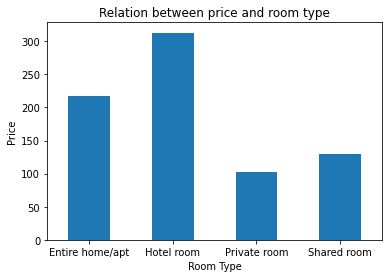

In [169]:
title_df = listings_df.groupby(['room_type'])['price'].mean()
ax = title_df.plot.bar(rot=0, title="Relation between price and room type")
ax.set_xlabel("Room Type")
ax.set_ylabel("Price")

As we can see, the most expensive room_type is a hotel room while the cheapest one is a private room. Shared room and Entire home/apt are intermediate options, which do not deviate a lot from each other. 

e) Plot on the NYC map the top 10 most expensive listings - (2.5 points)

In [153]:
# Get the rows with the 20 most expensive listings 
# Take 20 to eliminate as possible the probability that in the same building are included 2 or more options. 
cost_df = listings_df.nlargest(20,'price')
# New clean map instance
map_instance = folium.Map(location=default_location, zoom_start=10, control_scale=True)

array_unique = []
for _, row in cost_df.iterrows():
    if ([row['latitude'],row['longitude']] not in array_unique):
        marker = folium.Marker(location=[row['latitude'],row['longitude']],icon=folium.Icon(color="green"),popup="Most expensive listings")
        marker.add_to(map_instance)
        array_unique.append([row['latitude'],row['longitude']])
    if len(array_unique) == 10:
        break

map_instance

f) Plot on the NYC map the top 10 most reviewed listings - (2.5 points)


In [154]:
# Get the rows with the 20 most reviewed listings 
# Take 20 to eliminate as possible the probability that in the same building are included 2 or more options. 
review_df = listings_df.nlargest(20,'number_of_reviews')
array_unique = []
for _, row in review_df.iterrows():
    if ([row['latitude'],row['longitude']] not in array_unique):
        marker = folium.Marker(location=[row['latitude'],row['longitude']],icon=folium.Icon(color="blue"),popup="Most reviewed listings")
        marker.add_to(map_instance)
        array_unique.append([row['latitude'],row['longitude']])
    if len(array_unique) == 10:
        break

map_instance

g) Plot on the NYC map the top 10 most available listings - (2.5 points)

In [155]:
# Get the rows with the 10 most available listings 
# Take 20 to eliminate as possible the probability that in the same building are included 2 or more options. 
available_df = listings_df.nlargest(20,'availability_365')
array_unique = []
for _, row in available_df.iterrows():
    if ([row['latitude'],row['longitude']] not in array_unique):
        marker = folium.Marker(location=[row['latitude'],row['longitude']],icon=folium.Icon(color="red"),popup="Most available listings")
        marker.add_to(map_instance)
        array_unique.append([row['latitude'],row['longitude']])
    if len(array_unique) == 10:
        break

map_instance

h) Using `longitude`, `latitude`, `price`, and `number_of_reviews`, use Kmeans to create 5 clusters. Plot the points on the NYC map in a color corresponding to their cluster. - (5 points)


In [156]:
from sklearn.cluster import KMeans

# New clean map instance
map_instance = folium.Map(location=default_location, zoom_start=10, control_scale=True)

# Calculate cluster labels and add them to dataframe 
kmeans_df = listings_df[['longitude','latitude','price','number_of_reviews']].copy() 
kmeans = KMeans(n_clusters=5).fit(kmeans_df)
kmeans_df.loc[:,'labels'] = kmeans.labels_


# Color the markers on the map based on cluster label
for _, row in kmeans_df.iterrows():
    if row['labels'] == 0:
        marker = folium.CircleMarker(location=[row['latitude'],row['longitude']],icon=folium.Icon(color="red"),popup="Cluster 0",radius=5)
    elif row['labels'] == 1:
        marker = folium.CircleMarker(location=[row['latitude'],row['longitude']],icon=folium.Icon(color="blue"),popup="Cluster 1",radius=5)
    elif row['labels'] == 2:
        marker = folium.CircleMarker(location=[row['latitude'],row['longitude']],icon=folium.Icon(color="green"),popup="Cluster 2", radius =5)
    elif row['labels'] == 3:
        marker = folium.CircleMarker(location=[row['latitude'],row['longitude']],icon=folium.Icon(color="purple"),popup="Cluster 3", radius =5)
    else:
        marker = folium.CircleMarker(location=[row['latitude'],row['longitude']],icon=folium.Icon(color="black"),popup="Cluster 4",radius=5)
    marker.add_to(map_instance)

map_instance.save("index_h.html")


i) You should see points in the same cluster all over the map - briefly explain why that is. - (2.5 points)

It's a clear issue of suffering outliers for KMeans. In particular, the Kmeans algorithm is sensitive to outliers as the centroids are calculated by the mean of all the points in a single cluster. Datapoints are clustered based on not only locations, but also the price and number of reviews. Therefore, there are certain outliers that are driving the other clusters away from the dense region where all the datapoints are located.

j) How many clusters would you recommend using instead of 5? Display and interpret either the silhouette scores or the elbow method. - (5 points)

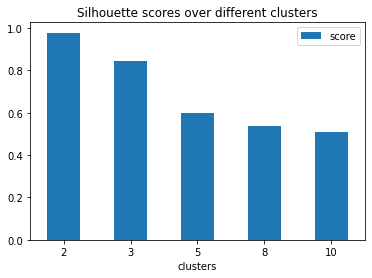

In [157]:
from sklearn.metrics import silhouette_score,silhouette_samples

silhouette_scores = []
kmeans_df = listings_df[['longitude','latitude','price','number_of_reviews']].copy() 
# Check set ups with different number of clusters.
list_clusters = [2,3,5,8,10]
for num_cluster in list_clusters:
    cluster_labels = KMeans(num_cluster).fit_predict(kmeans_df)
    silhouette_scores.append([str(num_cluster), silhouette_score(kmeans_df, cluster_labels)])

# Plot silhouette scores
silhouette_df = pd.DataFrame(silhouette_scores, columns=['clusters', 'score'])
ax = silhouette_df.plot.bar(x ='clusters', y = 'score',rot=0, title = "Silhouette scores over different clusters")

Based on the above plot, if we increase the number of clusters for the given data frame the silhouette scores decrease, while choosing a smaller number the scores are increasing. Since the silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters, so we have a better clustering I will choose 2 or 3 rather than 5.

k) Would you recommend normalizing the price and number of reviews? Briefly explain why. - (2.5 points)

To answer this question, I normalized both columns to check what is happening as I present in the below cell. As we can see by normalizing the two columns, the silhouette scores tend to be normalized too, which means that it is harder for the KMeans algorithm to descriminate the data points. Therefore, the normalization of those columns is a non-recommendated move.

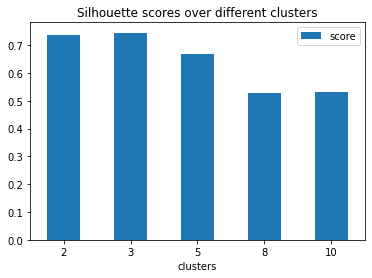

In [158]:
# Answer question k by normalizing value and number of reviews columns to check what is happening in the silhouette score. 

from sklearn.metrics import silhouette_score,silhouette_samples

silhouette_scores = []
kmeans_df = listings_df[['longitude','latitude','price','number_of_reviews']].copy() 
# Normalize value of price in dataframe 
kmeans_df['price'] = kmeans_df['price'] - kmeans_df['price'].mean()
standard_deviation = kmeans_df['price'].std()
kmeans_df['price'] = kmeans_df['price'] / standard_deviation

# Normalize value of reviews in dataframe 
kmeans_df['number_of_reviews'] = kmeans_df['number_of_reviews'] - kmeans_df['number_of_reviews'].mean()
standard_deviation = kmeans_df['number_of_reviews'].std()
kmeans_df['number_of_reviews'] = kmeans_df['number_of_reviews'] / standard_deviation

# Check set ups with different number of clusters.
list_clusters = [2,3,5,8,10]
for num_cluster in list_clusters:
    cluster_labels = KMeans(num_cluster).fit_predict(kmeans_df)
    silhouette_scores.append([str(num_cluster), silhouette_score(kmeans_df, cluster_labels)])

# Plot silhouette scores
silhouette_df = pd.DataFrame(silhouette_scores, columns=['clusters', 'score'])
ax = silhouette_df.plot.bar(x ='clusters', y = 'score',rot=0, title = "Silhouette scores over different clusters")

l) For all listings of type `Shared room`, plot the dendrogram of the hierarchical clustering generated from `longitude`, `latitude`, and `price`. - (5 points)


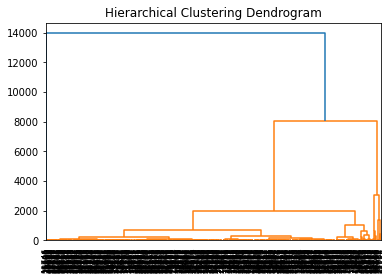

In [159]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram,linkage
import numpy as np

# Dataframe
dendro_df = listings_df.loc[listings_df['room_type'] == 'Shared room']
dendro_df = dendro_df[['latitude','longitude','price']] 
# Calculate the distance between each sample
Z = linkage(dendro_df, 'ward')
# Plot with Custom leaves
dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=dendro_df.index)
# Show the graph
plt.title("Hierarchical Clustering Dendrogram")
plt.show()



m) briefly comment on what you observe from the structure of the dendrogram.  - (2.5 points)

In dendograms the bigger the distance between the links, the bigger the difference in terms of the features. Based on that, in the above figure we see 2 easily discreminated horizontal lines at the top, so it would be a wise approach to "draw" our horizontal line of clustering over the 3 biggest clusters (close to 6000), since the rest of data points are quite similar.

n) Normalize the `price` as in b) and repeat l) - (2.5 points)

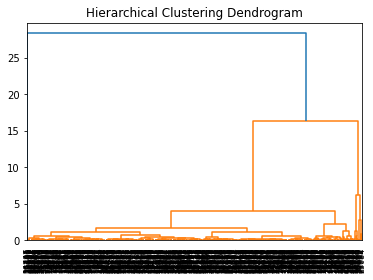

In [160]:
# Dataframe 
dendro_df = listings_df.loc[listings_df['room_type'] == 'Shared room']
dendro_df = dendro_df[['longitude','latitude','price']] 
# Normalize value of price in dataframe 
dendro_df['price'] = dendro_df['price'] - dendro_df['price'].mean()
standard_deviation = dendro_df['price'].std()
dendro_df['price'] = dendro_df['price'] / standard_deviation
# Calculate the distance between each sample
Z = linkage(dendro_df, 'ward')
# Plot with Custom leaves
dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=dendro_df.index)
# Show the graph
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


## Exercise 2 (50 points)

This exercise will be using the [mnist dataset](http://yann.lecun.com/exdb/mnist/).

a) Using Kmeans, cluster the images using 10 clusters and plot the centroid of each cluster. - (10 points)

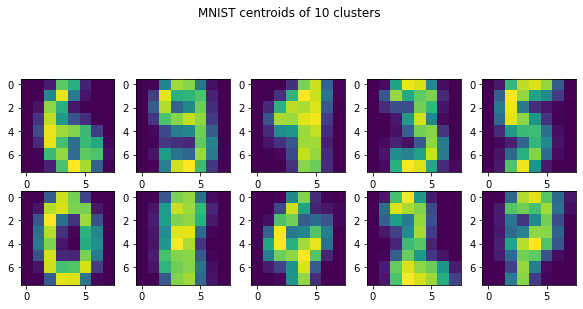

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
import numpy as np

mnist = load_digits()

# Initialize the K-Means model
kmeans = KMeans(n_clusters = 10)
# Fitting the model to image set
kmeans.fit(mnist.data)
#kmeans.fit(mnist.labels)
# Get centroids and nullify the normalization effect 
centroids = kmeans.cluster_centers_
# Reshape to turn the centroids into 
# a 2D representation form for visualization
centroids = centroids.reshape(10,8,8)

# Start ploting
fig = plt.figure(figsize = (10,10))
fig.suptitle('MNIST centroids of 10 clusters')
for i in range(10):
 plt.subplot(5,5,i+1)
 plt.imshow(centroids[i])


b) what is the disagreement distance between the clustering you created above and the clustering created by the labels attached to each image? Briefly explain what this number means in this context. - (10 points)

In [162]:
# Keep lecture's variable names for the two clusterings. 
C = kmeans.labels_
P = mnist.target

disagreement_distance = 0
for x in range(len(C)):
    for y in range(len(C)):
        # Check all possible combinations
        if y > x:
            # Check disaggrement distance cases
            if (C[x] == C[y] and P[x] != P[y]) or (C[x]!= C[y] and P[x]==P[y]):
                disagreement_distance += 1
print('The disaggrement distance is: {}'.format(disagreement_distance))

The disaggrement distance is: 98393


The number of disaggreement distance in the above code depicts the result of the comparison between the KMeans clustering and dataset's label clustering. Since we calculated all possible combinations between the 1797 data points (total combinations = (1797 choose 2) = 1613706)) and out of all these combinations only 107280 match in the same clusterings, we can easily extract the conclusion that those two clusterings are not similar.

c) Download the CIFAR-10 dataset [here](https://www.cs.toronto.edu/~kriz/cifar.html). Open `batch_1` by following the documentation on the web page. Plot a random image from the dataset. - (10 points)

Text(0.5, 1.0, 'bufo')

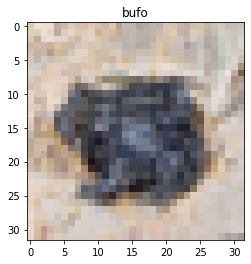

In [163]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

batch_1 = unpickle("cifar-10/data_batch_1")
batch_data = batch_1["data"]
batch_filenames = batch_1["filenames"]
# Pick a random image from batch data 
rand_number = np.random.randint(low = 0, high = batch_data.shape[0]-1)
image = batch_data[rand_number]
# Get the filename to use it on the picture
filename = batch_filenames[rand_number]
filename = filename.split("_")[0]
# Reshape random image from (3072,) to (3,32,32)
image = image.reshape(3,32,32)
# Transpose the image for ploting to (32,32,3)
image = image.transpose(1,2,0)
# Display the image
plt.imshow(image)
plt.title(filename)

d) This image is 32 x 32 pixels and each pixel is a 3-dimensional object of RGB (Red, Green, Blue) intensities. Using the same image as in c), produce an image that only uses 4 colors (the 4 centroids of the clusters obtained by clustering the image itself using Kmeans). - (10 points)

Text(0.5, 1.0, 'bufo')

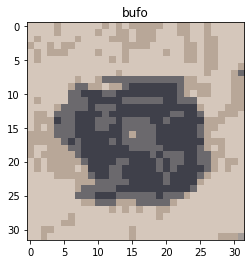

In [164]:
# Initialize the K-Means model
kmeans = KMeans(n_clusters = 4)
# Reshape random image from (32,32,3) to (1024,64)
image = image.reshape(32*32,3)
# Fitting the model to image set
kmeans.fit(image)
# Get centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
# Reconstruct the image based on the labels KMeans proposes.
for i in range(len(labels)-1):
    image[i] = centroids[labels[i]]
# Plot the produced image
image = image.reshape(32,32,3)
plt.imshow(image)
plt.title(filename)


e) Write a function that applies this transformation to the entire dataset for any number K of colors. - (10 points)

Text(0.5, 1.0, 'biplane')

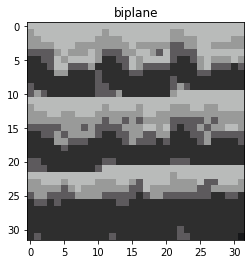

In [165]:
def transform(dataset, K):

    # Initialize the K-Means model
    kmeans = KMeans(n_clusters = K)
    # Apply the apply_transformation function over each input image 
    # of the dataset and receive a list of the reconstructed images of the K color clustering.
    return dataset.apply(lambda dataset: apply_transformation(dataset, kmeans), axis= 1).tolist()

def apply_transformation(image,kmeans):
    # Turn series to numpy 

    # Reshape random image from (3072,) to (1024,3)
    image = image.values.reshape(32*32,3)
    # Fitting the model to image set
    kmeans.fit(image)
    # Get centroids and labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    # Reconstruct the image based on the labels KMeans proposes.
    for i in range(len(labels)-1):
        image[i] = centroids[labels[i]]
    # Reshape random image from (1024,3) to (32,32,3) (ready for ploting)
    image = image.reshape(32,32,3)
    return image

cifar_df = pd.DataFrame(batch_data)
list_reconstructed_images = transform(cifar_df,K=4)

# Give an example of a reconstructed image
plt.imshow(list_reconstructed_images[1234])
# Get the filename to use it on the plot of the reconstructed image
filename = batch_filenames[1234]
filename = filename.split("_")[0]
plt.title(filename)